# Genetic algorithms experiments
![](https://cdn.atelier.bnpparibas/media/cache/archive/uploads/image/434150_atelier-chaine-adn.jpg)

##### References
- The excellent [blog post](http://blog.otoro.net/2017/10/29/visual-evolution-strategies/) on Otoro.net
- [Siraj Raval video](https://www.youtube.com/watch?v=rGWBo0JGf50) and [repo](https://github.com/llSourcell/Evolutionary_Space_Invaders)

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
plt.style.use('ggplot')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.color'] = "#d4d4d4"
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['lines.linewidth'] = 2

# Fitting a normal distribution

## Generate data

In [4]:
from scipy import stats

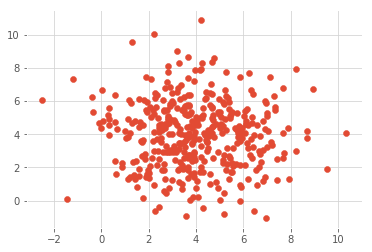

In [5]:
x1 = stats.norm.rvs(loc = 4,scale = 2,size = 400)
y1 = stats.norm.rvs(loc = 4,scale = 2,size = 400)

plt.scatter(x1,y1)
plt.show()

## Define objects

### Define a normal distribution

In [134]:
np.mean([1,2])

1.5

In [360]:
class Dist(object):
    def __init__(self,mu = None,std = None,label = None):
        self.mu = np.random.rand()*20 - 10 if mu is None else mu
        self.std = np.random.rand()*10 if std is None else std
        self.label = "" if not label else " - "+label
        self.func = lambda x : stats.norm.cdf(x,loc = self.mu,scale = self.std)
        
    def __repr__(self,markdown = False):
        return "Norm {1}mu={2}{0}, {0}std={3}{0}{4}".format("$" if markdown else "","$\\" if markdown else "",
                                                             round(self.mu,2),round(self.std,2),self.label)
        
    def plot(self,fill = True):
        x = np.linspace(-20, 20, 100)
        y = stats.norm.pdf(x,loc = self.mu,scale = self.std)
        plt.plot(x,y,label = self.__repr__(markdown = True))
        if fill:
            plt.fill_between(x, 0, y, alpha=0.4)
        
        
    def __add__(self,other):
        mu = np.mean([self.mu,other.mu])
        std = np.mean([self.std,other.std])
        return Dist(mu,std)
    
    def mutate(self,alpha = 1):
        self.mu = self.mu + 1/(1+np.log(1+alpha)) * np.random.randn()
        self.std = max(self.std + 1/(1+np.log(1+alpha)) * np.random.randn(),0.5)
        
    def fitness(self,x):
        return 1 - stats.kstest(x,self.func).statistic

In [205]:
d = Dist(4,2,label = "True")
d2 = Dist(-4,1)
print(d)
print(d2)

Norm mu=4, std=2 - True
Norm mu=-4, std=1


In [206]:
d + d2

Norm mu=0.0, std=1.5

In [207]:
d2.mutate()
d2

Norm mu=-2.72, std=0.51

### Define a population of distributions

In [369]:
class Population(object):
    def __init__(self,distributions = None,n = 100):
        if distributions is not None:
            self.distributions = distributions
        else:
            self.distributions = [Dist() for i in range(n)]
            
    def __getitem__(self,key):
        if type(key) == tuple or type(key) == list:
            d = []
            for i in key:
                d.append(self.distributions[i])
            return d
        else:
            return self.distributions[key]
    
    def __iter__(self):
        return iter(self.distributions)
    
    def __len__(self):
        return len(self.distributions)
    
    def plot(self,title = "Normal distributions",figsize = None):
        if figsize:
            plt.figure(figsize = figsize)
        plt.title(title)
        fill = len(self) < 5
        for d in self:
            d.plot(fill = fill)
        plt.legend()
        plt.xlabel("x")
        plt.show()
    
    def evaluate(self,x):
        fitnesses = [(i,dist.fitness(x)) for i,dist in enumerate(self)]
        indices,fitnesses = zip(*sorted(fitnesses,key = lambda x : x[1],reverse = True))
        return indices,fitnesses
    
    def selection(self,x,top = 0.1):
        indices,fitnesses = self.evaluate(x)
        n = int(top*len(fitnesses))
        return indices[:n]
    
    
    def crossover(self,indices):
        combinations = list(itertools.combinations(indices,2))
        np.random.shuffle(combinations)
        combinations = combinations[:len(self)]
        new_population = []
        for i,j in combinations:
            new_population.append(self[i]+self[j])
        self.distributions = new_population
            
    def mutate(self,generation = 1):
        for d in self:
            d.mutate(generation)
            
            
    def evolve(self,x,top = 0.25,n_generations = 20,last_selection = True):
        all_fitnesses = [self.evaluate(x)[1]]

        for generation in tqdm(range(n_generations)):

            indices = self.selection(x,top)
            self.crossover(indices)
            self.mutate(generation)
            
            indices,fitnesses = self.evaluate(x)
            all_fitnesses.append(fitnesses)
            
        self._plot_fitnesses(all_fitnesses)
        
        if last_selection:
            indices = self.selection(x,top)
    
        return Population(self[indices])
    
    
    def _plot_fitnesses(self,fitnesses):
        sups = []
        infs = []
        means = []
        for step in fitnesses:
            sups.append(np.max(step))
            infs.append(np.min(step))
            means.append(np.mean(step))
            
        plt.figure(figsize=(10,6))
        plt.plot(means)
        plt.fill_between(range(len(means)),sups,infs, alpha = 0.2)
        plt.xlabel('# Generation')
        plt.ylabel('Fitness')
        plt.legend()
        plt.show()

In [373]:
pop = Population(n = 3)

In [374]:
pop[0]

Norm mu=-0.4, std=5.98

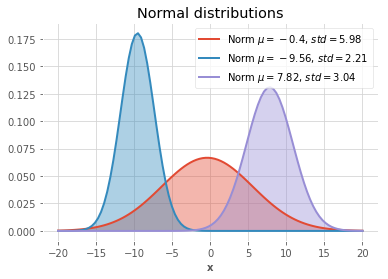

In [375]:
pop.plot()

## Create the fitness function

##### Test of the Kolmogorov-Smirnov test

In [103]:
import seaborn as sns

In [124]:
mus = np.linspace(0,5,100)
stds = np.linspace(1,5,50)
ks = []
for std in stds:
    ksi = []
    for mu in mus: 
        ksi.append(stats.kstest(x1,Dist(mu,std).func).statistic)
    ks.append(ksi)

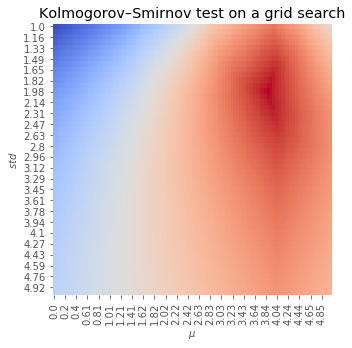

In [132]:
plt.figure(figsize = (5,5))
plt.title("Kolmogorov–Smirnov test on a grid search")
sns.heatmap(pd.DataFrame(ks,columns = np.round(mus,2),index = np.round(stds,2)),cbar = False,cmap = plt.cm.coolwarm_r)
plt.xlabel("$\mu$")
plt.ylabel("$std$")
plt.show()

## Genetic algorithm

In [376]:
pop = Population(n = 50)

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 28.45it/s]


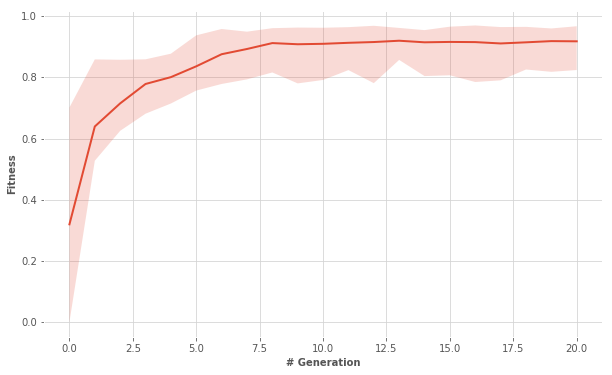

In [377]:
new_pop = pop.evolve(x1,n_generations=20)

In [378]:
len(new_pop)

12

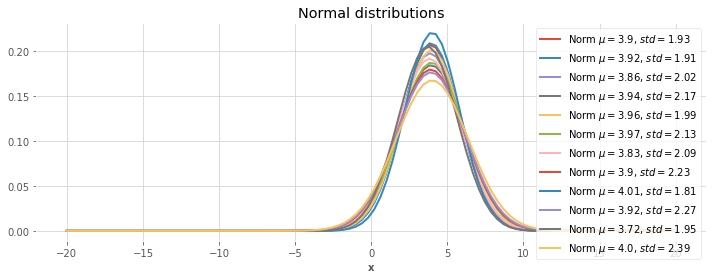

In [379]:
new_pop.plot(figsize = (12,4))

# Fitting a logistic regression with PyTorch

In [3]:
import experiments

## Preparing the data

### Creating a classification dataset via sklearn helpers

In [19]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

In [8]:
X,y = load_boston(return_X_y=True)

In [12]:
np.mean(y)

22.532806324110677

In [15]:
y = (y > np.mean(y)).astype(int)

In [17]:
pd.Series(y).value_counts()

0    297
1    209
dtype: int64

### Fitting a logistic regression to have a benchmark

In [21]:
cross_val_score(LogisticRegression(),X,y,cv = 3)

array([ 0.89940828,  0.79881657,  0.8452381 ])

In [22]:
lr = LogisticRegression()
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [169]:
np.log(lr.predict_proba(X)[:,1])

array([  9.34835670e-01,   4.65580167e-01,   9.55070829e-01,
         9.54246024e-01,   9.14810855e-01,   7.55201881e-01,
         2.96546293e-01,   3.01533035e-02,   3.85588978e-04,
         3.84842614e-02,   2.43903219e-02,   1.46096026e-01,
         1.89493370e-01,   2.30108087e-01,   1.16271853e-01,
         2.20855251e-01,   5.05194696e-01,   3.26323632e-02,
         7.18639211e-02,   9.15038361e-02,   1.94090340e-03,
         3.89402541e-02,   1.14748666e-02,   3.74600211e-03,
         1.34243548e-02,   6.08334749e-03,   1.58637601e-02,
         9.41396775e-03,   8.79879257e-02,   1.70228630e-01,
         1.28322765e-03,   4.02265307e-02,   3.42420471e-04,
         5.48744957e-03,   3.54193243e-03,   4.22252866e-01,
         2.81942479e-01,   5.38071852e-01,   5.47023629e-01,
         9.67768435e-01,   9.93005926e-01,   9.60247202e-01,
         8.59416306e-01,   8.05735443e-01,   4.50446883e-01,
         3.53068045e-01,   1.62907906e-01,   1.68734594e-02,
         1.14890527e-04,

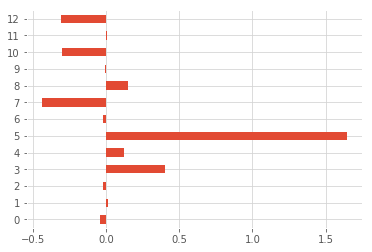

In [26]:
pd.Series(lr.coef_[0]).plot(kind = "barh")

## Fitting the logreg with GA

In [129]:
from torch.autograd import Variable
import torch

In [130]:
logreg = experiments.LogReg(n_feature=13,n_output=1)

In [133]:
pop = experiments.PopulationLogReg(X,y,n=50,n_feature = 13,n_output = 1,alpha = 1)

100%|████████████████████████████████████████| 100/100 [00:09<00:00, 10.45it/s]


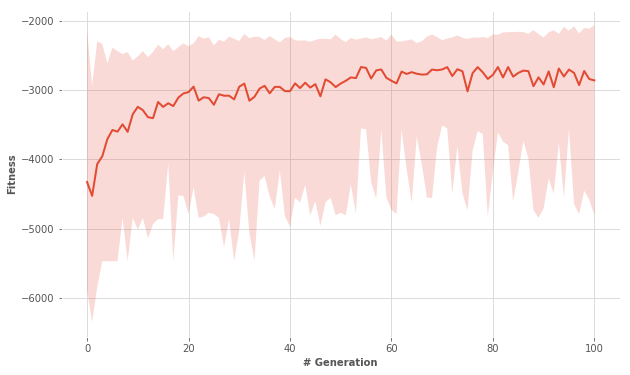

In [134]:
new_pop = pop.evolve(n_generations=100)

## Comparing the results

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

##### Confusion matrix

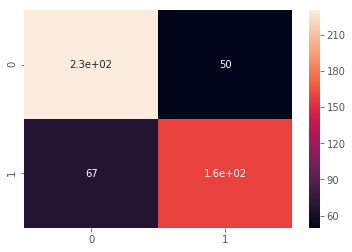

In [143]:
sns.heatmap(confusion_matrix(new_pop[0].forward(X).data.numpy().reshape(-1) > 0.5,y),annot=True)

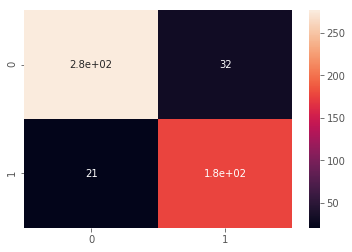

In [144]:
sns.heatmap(confusion_matrix(lr.predict(X),y),annot=True)

###### Prediction distribution

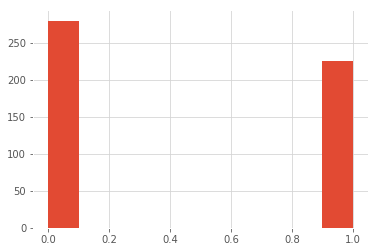

In [142]:
plt.hist(new_pop[0].forward(X).data.numpy().reshape(-1))
plt.show()

##### Coefficients

In [150]:
lr.coef_

array([[-0.03990259,  0.00939368, -0.02222431,  0.40014811,  0.12213145,
         1.64318174, -0.02151301, -0.43774626,  0.15000064, -0.00539679,
        -0.29883838,  0.00388647, -0.30764979]])

In [157]:
d = pd.DataFrame([new_pop[0].out.weight.data.numpy()[0],lr.coef_[0]]).transpose()
d / d.abs().max(axis = 0)

,0,1
0,0.159669,-0.024284
1,0.401426,0.005717
2,-0.688072,-0.013525
3,-0.650651,0.243520
4,0.163215,0.074326
5,0.012135,1.000000
6,-0.296003,-0.013092
7,-0.278384,-0.266402
8,-0.045301,0.091287
9,-0.174161,-0.003284


## Changing parameters

### Impact of the fittest ratio

- Generations 50
- Fittest : 12
- Offsprings : 66


100%|████████████████████████████████████████| 100/100 [00:05<00:00, 17.12it/s]


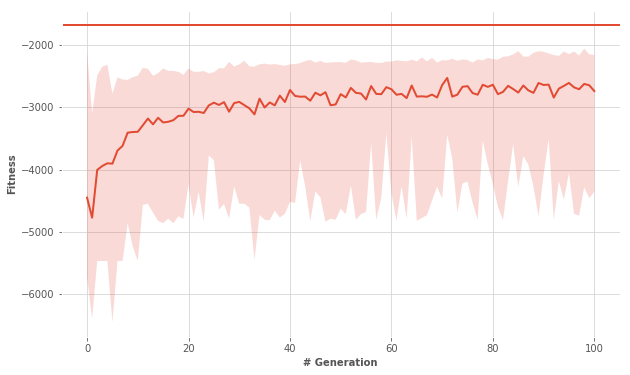

In [171]:
pop = experiments.PopulationLogReg(X,y,n=50,n_feature = 13,n_output = 1,alpha = 1)
new_pop = pop.evolve(n_generations=100)

- Generations 50
- Fittest : 5
- Offsprings : 10


100%|████████████████████████████████████████| 100/100 [00:10<00:00,  9.94it/s]


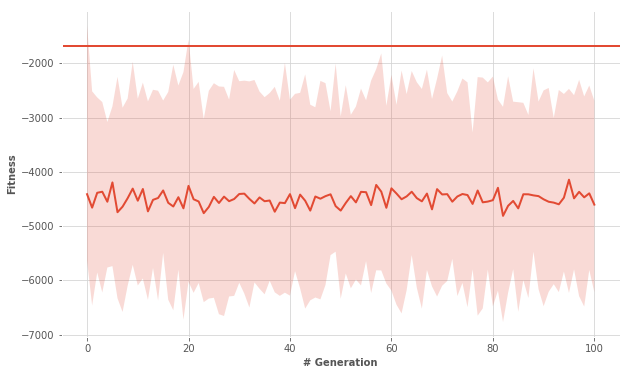

In [172]:
pop = experiments.PopulationLogReg(X,y,n=50,n_feature = 13,n_output = 1,alpha = 1)
new_pop = pop.evolve(n_generations=100,top = 0.1)

- Generations 50
- Fittest : 25
- Offsprings : 300


100%|████████████████████████████████████████| 100/100 [00:06<00:00, 16.05it/s]


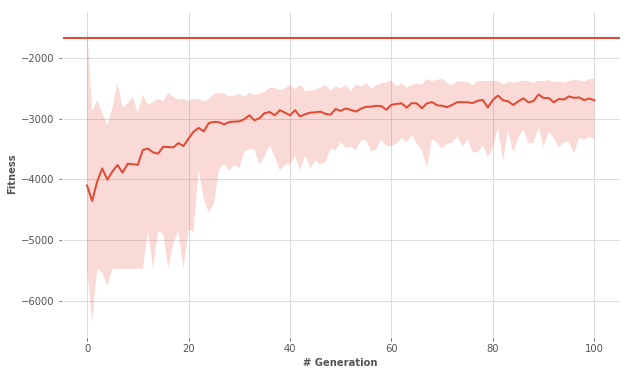

In [173]:
pop = experiments.PopulationLogReg(X,y,n=50,n_feature = 13,n_output = 1,alpha = 1)
new_pop = pop.evolve(n_generations=100,top = 0.5)

### Impact of the generation size

In [ ]:
pop = experiments.PopulationLogReg(X,y,n=250,n_feature = 13,n_output = 1,alpha = 1)
new_pop = pop.evolve(n_generations=100,top = 0.1)

- Generations 250
- Fittest : 25
- Offsprings : 300


 24%|█████████▊                               | 24/100 [00:21<01:08,  1.11it/s]